In [3]:
# 1.IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import kagglehub

# Set plotting style
sns.set(style='whitegrid')

# 2. LOAD DATASET FROM KAGGLEHUB
path = kagglehub.dataset_download("kartik2112/fraud-detection")
print("Path to dataset files:", path)

# Load CSV file (adjust file name based on actual contents)
df = pd.read_csv(path + "/fraudTrain.csv")  # Update with correct filename if different
print("Initial shape:", df.shape)

# 3. DATA EXPLORATION & PREPROCESSING
# Preview data
df.head()

# Drop duplicates if any
df.drop_duplicates(inplace=True)

# Check for missing values
print("\nMissing values per column:\n", df.isnull().sum())

# Convert 'trans_date_trans_time' to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# Create time-related features
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['weekday'] = df['trans_date_trans_time'].dt.weekday

# Encode categorical features
label_cols = ['category', 'gender', 'city', 'state', 'job', 'merchant']
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Drop unneeded columns
drop_cols = ['cc_num', 'trans_num', 'first', 'last', 'dob', 'street', 'city_pop', 'unix_time', 'trans_date_trans_time']
df.drop(columns=drop_cols, inplace=True)

# Normalize the transaction amount
scaler = StandardScaler()
df['amt'] = scaler.fit_transform(df[['amt']])

# Final shape after preprocessing
print("Shape after preprocessing:", df.shape)

# Class distribution
print("\nFraudulent transaction distribution:")
print(df['is_fraud'].value_counts(normalize=True))


Path to dataset files: /kaggle/input/fraud-detection
Initial shape: (1296675, 23)

Missing values per column:
 Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64
Shape after preprocessing: (1296675, 17)

Fraudulent transaction distribution:
is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64



Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    257834
           1       0.04      0.69      0.08      1501

    accuracy                           0.90    259335
   macro avg       0.52      0.80      0.51    259335
weighted avg       0.99      0.90      0.94    259335

ROC AUC Score: 0.8176698235265606


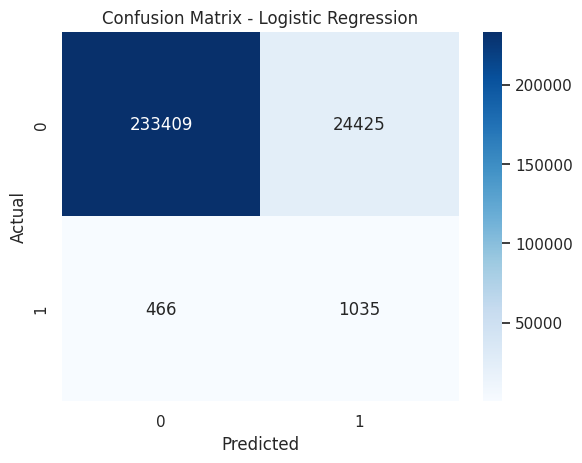


Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:51:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    257834
           1       0.43      0.95      0.59      1501

    accuracy                           0.99    259335
   macro avg       0.71      0.97      0.79    259335
weighted avg       1.00      0.99      0.99    259335

ROC AUC Score: 0.9984906636523961


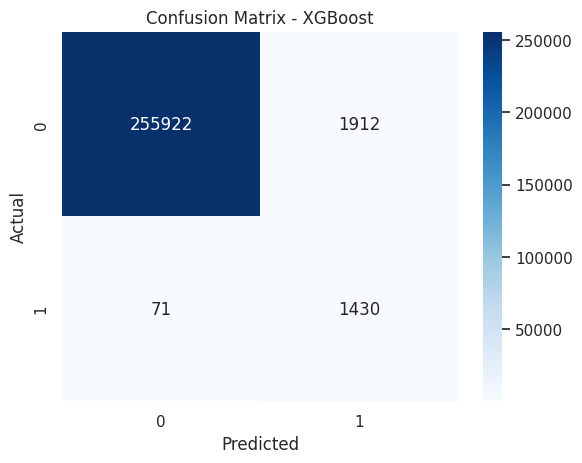

In [4]:
# 4. TRAIN/TEST SPLIT
from sklearn.model_selection import train_test_split

# Define features and target
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Train-test split (Stratify to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 5. MODEL TRAINING
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'XGBoost': XGBClassifier(scale_pos_weight=(y == 0).sum() / (y == 1).sum(), use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [5]:
# Predict with best performing model (let's assume it's XGBoost for explanation)
best_model = models['XGBoost']
y_pred = best_model.predict(X_test)

# False Positives (Predicted Fraud, Actually Legit)
false_positives = X_test[(y_pred == 1) & (y_test == 0)]
print(f"\nNumber of False Positives: {len(false_positives)}")

# False Negatives (Predicted Legit, Actually Fraud)
false_negatives = X_test[(y_pred == 0) & (y_test == 1)]
print(f"Number of False Negatives: {len(false_negatives)}")

# Display a few examples of each
print("\nSample False Positives:")
display(false_positives.head())

print("\nSample False Negatives:")
display(false_negatives.head())



Number of False Positives: 1912
Number of False Negatives: 71

Sample False Positives:


,Unnamed: 0,merchant,category,amt,gender,city,state,zip,lat,long,job,merch_lat,merch_long,hour,day,weekday
1136508,1136508,676,9,-0.298979,0,608,15,47451,38.8938,-86.5246,113,39.804900,-87.153371,22,18,5
1198907,1198907,174,11,11.296559,0,796,49,26292,39.1505,-79.5030,200,38.227950,-78.632324,13,16,5
1052962,1052962,424,7,-0.386181,0,530,38,16858,41.0001,-78.2357,133,41.688743,-77.451485,23,12,3
701186,701186,349,8,7.780004,1,143,15,46723,41.2290,-85.3244,391,40.906072,-85.830039,18,26,5
18478,18478,479,3,-0.351001,1,276,35,43321,40.4971,-82.8342,189,41.449189,-82.949645,4,12,5



Sample False Negatives:


,Unnamed: 0,merchant,category,amt,gender,city,state,zip,lat,long,job,merch_lat,merch_long,hour,day,weekday
80041,80041,625,2,-0.288000,1,72,34,12410,42.0740,-74.4530,368,42.347885,-73.908154,7,17,6
411829,411829,382,10,-0.308709,0,387,50,82063,41.0539,-106.0763,377,40.672427,-106.124137,20,5,4
474925,474925,588,3,-0.401588,1,99,34,10463,40.8798,-73.9067,466,40.513556,-73.927791,1,28,6
1140960,1140960,105,11,6.257885,1,497,9,32935,28.1384,-80.6524,119,27.243851,-81.612613,14,20,0
758782,758782,60,7,-0.317068,1,672,43,79252,34.2956,-99.7494,271,34.584884,-99.838128,21,20,2



SHAP explanation for a False Positive sample:


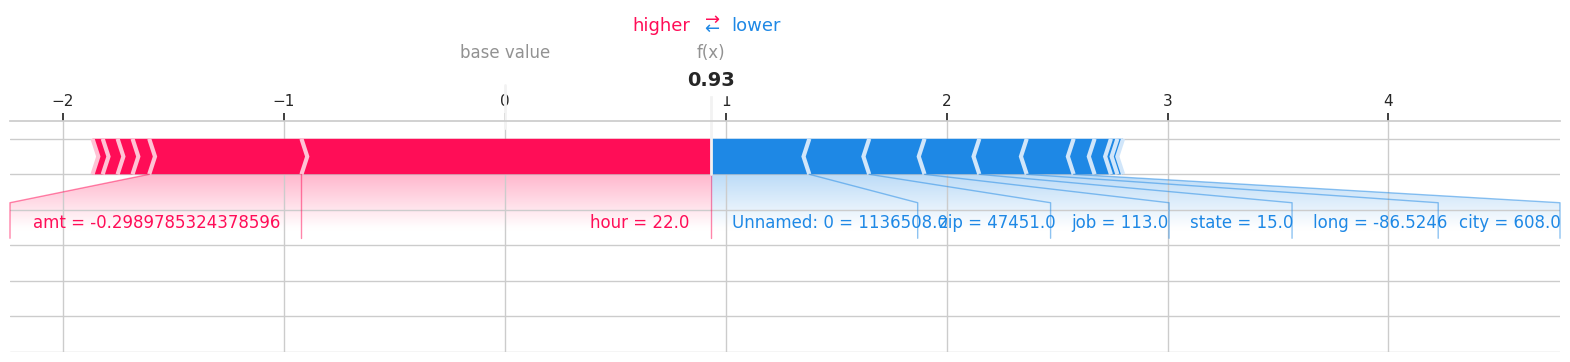

In [13]:
import shap
# Reset index to align with shap_values array
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)
y_pred_reset = pd.Series(best_model.predict(X_test_reset))

# Identify false positives using position instead of index
false_positive_mask = (y_test_reset == 0) & (y_pred_reset == 1)
false_positive_indices = np.where(false_positive_mask)[0]  # returns array of row positions

# Pick first false positive sample
idx = false_positive_indices[0]

# SHAP explanation for that sample
print("\nSHAP explanation for a False Positive sample:")
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    X_test_reset.loc[idx],
    matplotlib=True  # ensures compatibility with Colab
)


In [14]:
y_proba = best_model.predict_proba(X_test_reset)
print("f(x) =", y_proba[idx, 1])  # This gives the predicted probability for fraud


f(x) = 0.7092482


In [15]:
import joblib
joblib.dump(best_model, 'fraud_detection_model.pkl')
false_positives.to_csv("false_positives.csv")
false_negatives.to_csv("false_negatives.csv")
